# 4. Content-based filtering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict

In [2]:
%run "01.Recommendation_Loading.ipynb"

################  Recommendations (all data, positive recommendations only) ################
Users: 12,636,209
Games: 37,419
Number of users 2,000
First five users id [11203022 12827342 11719330  9553563 11051045]
################  Recommendations (Sample) ################
Minimum number of recommendations to be included in the sample: 20
Number of randomly selected users: 2000
Users: 1,991
Games: 11,108
################ User-Game Matrix ################
Number of Rows: 1,992
Numbeer of Columns: 11,109
Number of stored values: 75,831


In [3]:
%run "04.Games_Exploration.ipynb"

There are 50872 distinct games
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
There are 50872 distinct games


/var/folders/h5/_4d00bcd69b71883jm4jldn40000gn/T/ipykernel_31806/2151291458.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  games_joined.groupby("_merge").count()["app_id"]


There are 441 tags
The top 10 tags with their respective count are: [('Indie', 27957), ('Singleplayer', 22566), ('Action', 21897), ('Adventure', 20183), ('Casual', 17844)]
<class 'pandas.core.frame.DataFrame'>
Index: 49628 entries, 10 to 2515460
Columns: 441 entries, 1980s to eSports
dtypes: int8(441)
memory usage: 21.3 MB


In [4]:
matrix_games_tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49628 entries, 10 to 2515460
Columns: 441 entries, 1980s to eSports
dtypes: int8(441)
memory usage: 21.3 MB


### Dimensionality Reduction

Principal Component Analysis is conducted to reduce the number of game tags.

In [5]:
pca = PCA(n_components=len(matrix_games_tags.columns))
pca.fit(matrix_games_tags)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

The suitable value of k for PCA with a threshold of 0.95 is: 247


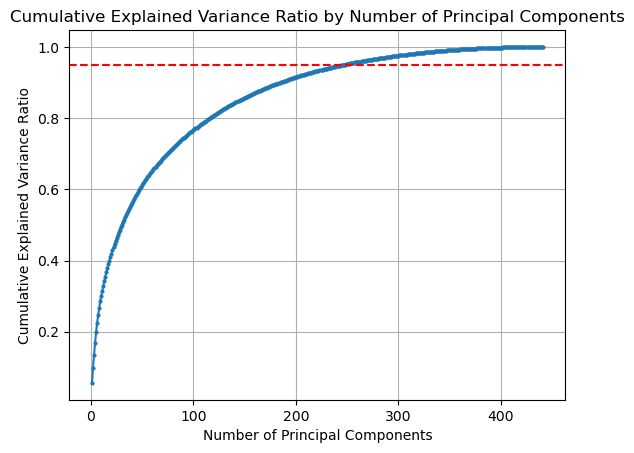

In [32]:
# Finding the suitable value of k
k = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print("The suitable value of k for PCA with a threshold of 0.95 is:", k)

# View cumulative explained variance ratio with threshold
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', markersize=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold: 0.95')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.grid(True)
plt.show()

In [7]:
N = 10
k = 250
# Dimensionality Reduction: Apply PCA
pca = PCA(n_components=k)  # Set the desired number of components, k
reduced_features = pca.fit_transform(matrix_games_tags)

# Convert the reduced_features array back to a DataFrame
reduced_matrix_games_tags = pd.DataFrame(reduced_features, index=matrix_games_tags.index)

# Content-based Filtering (Similarity)
# Calculate similarity matrix
similarity_matrix = cosine_similarity(reduced_matrix_games_tags)

In [8]:
# Example on one game
selected_game_id = 12345  # Choose the game ID for which you want to find similar games
similarity_scores = similarity_matrix[selected_game_id]
similar_games_indices = similarity_scores.argsort()[::-1][:N]  # Select top N similar games

recommended_games = matrix_games_tags.iloc[similar_games_indices].index.tolist()

In [16]:
%run "Get_Training_and_Test_Instances.ipynb"

################  Get Test Data ################


/var/folders/h5/_4d00bcd69b71883jm4jldn40000gn/T/ipykernel_31806/520038405.py:7: FutureWarning: The provided callable <function nanmax at 0x10472f420> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()
/var/folders/h5/_4d00bcd69b71883jm4jldn40000gn/T/ipykernel_31806/520038405.py:9: FutureWarning: The provided callable <function nanmax at 0x10472f420> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  rec_df = df.groupby("user_id_categorical").agg({"app_id_categorical": np.nanmax}).reset_index()


x_test.shape: (1991, 2)
y_test.shape: (1991, 1)
Number of Users: 1,992
Number of Games: 11,109
Number of Negatives Sample per User-Game: 2
################  Get Training Data ################
x_train.shape: (226592, 2)
y_train.shape: (226592, 2)


In [26]:
### get the N most similar games to recommend
def get_similar_games(games_tags, sim_matrix, x_user_game, N): 
    rec_sim = defaultdict(lambda: {"games": [], "scores": []})
    for user_id, game_id in x_user_game:
        sim_scores = sim_matrix[game_id]
        sim_games_indices = sim_scores.argsort()[::-1][:N]
        recommended_games = games_tags.iloc[sim_games_indices].index.tolist()
        recommended_scores = sim_scores[sim_games_indices]

        # Store the list of best game IDs and the similarity scores in rec_sim for the user
        for game, score in zip(recommended_games, recommended_scores):
            if game in rec_sim[user_id]["games"]:
                index = rec_sim[user_id]["games"].index(game)
                rec_sim[user_id]["scores"][index] = max(rec_sim[user_id]["scores"][index], score)
            else:
                rec_sim[user_id]["games"].append(game)
                rec_sim[user_id]["scores"].append(score)

    rec_sim_final = []
    # Choose the best N games for each user based on the scores
    for user_id in rec_sim:
        user_rec = rec_sim[user_id]
        sorted_indices = np.argsort(user_rec["scores"])[::-1][:N]
        user_rec_games = [user_rec["games"][i] for i in sorted_indices]
        rec_sim_final.append([user_id, user_rec_games])

    return rec_sim_final

In [33]:
hgr_sim_list = []
for k in range(50):
    recommendations_sim = get_similar_games(reduced_matrix_games_tags, similarity_matrix, x_train, k)
    hgr_sim = eval_hit_ratio_sim(recommendations_sim, x_test)
    hgr_sim_list.append(hgr_sim)
    print("Top @", k, "popular games,", "Hit Gain Ratio", '{0:.4%}'.format(hgr_sim))
    

In [ ]:
plt.plot(hgr_sim_list, label="Hit Gain Ratio")
plt.title("Content-based Model")
plt.xlabel("Top @K similar games")
plt.ylabel("HGR")
plt.legend()
plt.show()